# Milvus Create collection and Retrieve results test

1. Using definitions from the Medical Device Regulation in the MDR_3Columns.csv
    * embeddings were created, for each definition, with the library "sentence-transformers".
2. Storing those embeddings in the vector db along with metadata.
3. Creating pipeline to pass a query and retrieve similar records.
    * the query was created by selecting a sequence of characters of random length in random rows of MDR_3Columns.csv
4. Updating vector db index with new records
5. Deleting records from vector db index.
6. Storing information about latency and using HNSW to search for results as this strategy seems to be the most used.

About search strategies and other vector db considerations:
https://thedataquarry.com/posts/vector-db-4/#4-recall-vs-latency


### Considerations about using Milvus in Python

#### **Recommended tools:**

 - Anaconda to create a python virtual environment:

https://www.anaconda.com/download/

 - Visual Studio Code to work with the scripts:

 https://code.visualstudio.com/download

#### **Installation:**

 - Windows Subsystem for Linux (WSL):

 https://learn.microsoft.com/en-us/windows/wsl/install

 - Docker:

https://docs.docker.com/desktop/install/windows-install/

 - Run the docker-compose.yml following the instructions here:

https://milvus.io/docs/install_standalone-docker.md

when pip installing pymilvus, grpcio (setup.py) times out.

 * One solution is to create environment with python 3.7.0

and to pip install pymilvus==2.3.0

other dependencies in this notebook:

pip install sentence-transformers to create embeddings

#### **detailed steps:**

1. create a virtual environment (MDRassistant is the name of the environment):

conda create -n MDRassistant python=3.7.0 

2. activate the newly created conda environment:

conda activate MDRassistant

3. install python packages:

conda install -n MDRassistant ipykernel --update-deps --force-reinstall

pip install pymilvus==2.3.0

pip install sentence-transformers



#### **Usage:**

The query vector needs to be a nested list or nested array of vector(s). E.g. query = [[vector]] or queries = [[query_vector1],[query_vector2],...]

When inserting data into a collection with the method insert(), it is necessary to call the flush() method afterwards. Otherwise, the collection is not indexed unless the amount of data inserted reaches a certain number and the collection is 'sealed'. Calling flush() seales the collection. In practice, Milvus recommends to not call flush() too often to avoid segmenting the storage which could create computationally inneficient search.

About inserting data.

documentation:
https://milvus.io/docs/insert_data.md

Issure reported here:
https://github.com/milvus-io/milvus/issues/20753

Performance metrics:

https://learn.deeplearning.ai/building-evaluating-advanced-rag


### SETUP

Milvus docker-compose container should be running

In [1]:
from sentence_transformers import SentenceTransformer, util

from colorama import Fore, Back, Style
import numpy as np
import time
import difflib

from pymilvus import (
    connections,
    utility,
    FieldSchema, CollectionSchema, DataType,
    Collection,
)

# importing .csv with the database to query
#   and creating a list of definitions and a list of chapters and articles as metadata

import csv

with open('MDR_3Columns.csv', newline='') as f:
    reader = csv.reader(f)
    definitions = []
    metaData = []
    for row in reader:
        metaData.append(row[0] + ": " + row[1])
        definitions.append(row[2])

model = SentenceTransformer("all-MiniLM-L6-v2")
model.max_seq_length = 400

# Sentences are encoded by calling model.encode()
embeddings_MDR = model.encode(definitions, normalize_embeddings=True)


c:\Users\Alberto\.conda\envs\MDRassistant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### QUERY vector

A number of query vectors are created as sequences of consecutive characters in random paragraphs in the "definitions" list. 


In [2]:
def selectQueries(data, nQueries):
    ''' 
    Retrieve a number of queries from random rows in the data. 
    Queries are made of a sequence of consecutive characters starting at random places in the selected row of the data.
        Queries have random lengths.
    '''
    lengthList = len(data)
    idx_data = np.random.randint(lengthList,size=nQueries)
    idx_data = list(range(lengthList))
    np.random.shuffle(idx_data)
    idx_data = idx_data[:nQueries]
    qq_emb = []
    q_text = []
    query = []
    for iQuery in idx_data:
        text = data[iQuery]
        starting_point = int(np.random.randint(int(len(text)/2),size=1))
        end_point = int(np.random.randint(int(1.2*starting_point),len(text),size=1))
        query = text[starting_point:end_point]
        q_text.append(query)
        query_vect = model.encode(query, normalize_embeddings=True)
        qq_emb.append(query_vect)
    return qq_emb, q_text, idx_data

def printTextQuery(text, query, isShow=False):
    '''
    Visualize the text of the search result and the sequence of characters that represents the query
        if such a sequence is present in the text.
    '''
    foundQuery = 0
    if text.find(query) >=0:            # find return position of string if found else -1
        foundQuery = 1
        if isShow:
            whereQueryStart = text.find(query)
            whereQueryEnd = whereQueryStart + len(query)
            snippet_pre = text[:whereQueryStart]
            snippet = query
            snippet_post = text[whereQueryEnd:]

            print("Query: " + query)
            print("Text containing the query: " + snippet_pre + Fore.BLACK + Back.GREEN + snippet + Style.RESET_ALL + snippet_post)
    else:
        if isShow:
            print("Query: " + query)
            print("Text containing the query:" + Fore.BLACK + Back.YELLOW +  "not found" + Style.RESET_ALL)

    return foundQuery
        



In [3]:
# randomly selecting queries

nQueries = 2
vectors_to_search, query_text, id_definitions = selectQueries(definitions, nQueries)

for iQuery in range(len(id_definitions)):
    text = definitions[id_definitions[iQuery]]
    query = query_text[iQuery]
    printTextQuery(text, query, True)


Query: egulation (EU) 2017/746 of the European Parliament and of the Council (25), to provide advice to the Commission and to assist the Commission and the Member States in ensuring a harmonised implementation of this Regulation. The MDCG should be able to establish subgroups in order to have access to necessary in-depth technical expertise in the field of medical devices including in vitro diagnostic medical devices. When establishing subgroups, appropriate consideration should be given to the possibility of involving existing groups at Un
Text containing the query: An expert committee, the Medical Device Coordination Group (MDCG), composed of persons designated by the Member States based on their role and expertise in the field of medical devices including in vitro diagnostic medical devices, should be established to fulfil the tasks conferred on it by this Regulation and by Regulation (EU) 2017/746 of the European Parliament and of the Council (25), to provide advice to the Commissi

In [5]:
fmt = "\n=== {:30} ===\n"
search_latency_fmt = "search latency = {:.4f}s"

num_entities, dim = np.shape(embeddings_MDR)[0], np.shape(embeddings_MDR)[1]
print('Number of dimensions: ' + str(dim))

connections.connect("default", host="localhost", port="19530")

has = utility.has_collection("hello_milvus")
print(f"Does collection hello_milvus exist in Milvus: {has}")

fields = [
    FieldSchema(name="pk", dtype=DataType.VARCHAR, is_primary=True, auto_id=False, max_length=100),
    FieldSchema(name="metadata_chapter_article", dtype=DataType.VARCHAR, max_length=100),
    FieldSchema(name="embeddings", dtype=DataType.FLOAT_VECTOR, dim=dim),
]

schema = CollectionSchema(fields, "hello_milvus is the simplest demo to introduce the APIs")

hello_milvus = Collection("hello_milvus", schema, consistency_level="Strong")

entities = [
    # provide the pk field because `auto_id` is set to False
    [str(i) for i in range(num_entities)],
    metaData, # text metadata
    embeddings_MDR, # field embeddings, supports numpy.ndarray and list
]

insert_result = hello_milvus.insert(entities)
hello_milvus.flush()

print(f"Number of entities in Milvus: {hello_milvus.num_entities}")  # check the num_entites

### IVF_FLAT type of indexing

# index = {
#     "index_type": "IVF_FLAT",
#     "metric_type": "L2",
#     "params": {"nlist": 128},
#     # "params": {"nlist": 4096}, # "params": {"nlist": 128},
# }
# search_params = {
#     "metric_type": "L2",
#     # "params": {"nprobe": 10},
#     "params": {"nprobe": 128}, # "params": {"nprobe": 10},
# }

### HNSW type of indexing

index = {"metric_type": "L2", "index_type": "HNSW", "M": 64, "efConstruction": 80}
search_params = {"ef": 20}

hello_milvus.create_index("embeddings", index)

hello_milvus.load()

start_time = time.time()
nResults = 1
result = hello_milvus.search(vectors_to_search, "embeddings", search_params, limit=nResults)
end_time = time.time()

print(search_latency_fmt.format(end_time - start_time))

isVisualizeResults = True
if isVisualizeResults:
    for iQuery in range(len(result)):
        print('\n \t Query ' + str(iQuery))
        for iResult in range(nResults):  
            print('\t Result ' + str(iResult))
            print('Distance: ' + str(result[iQuery].distances[iResult]))
            query =  query_text[iQuery]
            text = definitions[int(result[iQuery].ids[iResult])]
            printTextQuery(text, query, True)


utility.drop_collection("hello_milvus")
connections.disconnect("default")


Number of dimensions: 384


MilvusException: <MilvusException: (code=2, message=Fail connecting to server on localhost:19530. Timeout)>

# Latency 

### CREATE 

Create collection of 1 , 10 and 100 elements

In [9]:
def createCollectionMilvus(data, metaData, collection_name="default_collection", connection_name="default"):
    try:
        num_entities, dim = np.shape(data)[0], np.shape(data)[1]
        print('\nNumber of entries to input: ' + str(num_entities))
        print('Number of dimensions: ' + str(dim))
        connections.connect(connection_name, host="localhost", port="19530")


        fields = [
            FieldSchema(name="pk", dtype=DataType.VARCHAR, is_primary=True, auto_id=False, max_length=100),
            FieldSchema(name="metadata", dtype=DataType.VARCHAR, max_length=100),
            FieldSchema(name="embeddings", dtype=DataType.FLOAT_VECTOR, dim=dim),
        ]

        schema = CollectionSchema(fields, "a milvus collection named: " + collection_name)
        collection_object = Collection(collection_name, schema, consistency_level="Strong")

        if utility.has_collection(collection_name):
            print(f"Collection " + collection_name + " was created.")
        else:
            print(f"Collection: " + collection_name + " doesn't exist.")

        entities = [
            # provide the pk field because `auto_id` is set to False
            [str(i) for i in range(num_entities)],
            metaData, # text metadata
            data,  # field embeddings, supports numpy.ndarray and list
        ]

        collection_object.insert(entities)
        collection_object.flush()
        print(f"Number of entities entered in collection {collection_name} : {collection_object.num_entities}")  # check the num_entites

        index = {"metric_type": "L2", "index_type": "HNSW", "M": 64, "efConstruction": 80}
        

        collection_object.create_index("embeddings", index)
        collection_object.load()

        return collection_object
    except:
        utility.drop_collection(collection_name)
        connections.disconnect(connection_name)

    

In [12]:
collectionLatency = []
nSamples = [1, 10, 100]
collection_name = "collection_test"

for iTestCollection in nSamples:
    nEmbeddings = iTestCollection
    try:
        start_time = time.time()
        createCollectionMilvus(embeddings_MDR[:nEmbeddings], metaData[:nEmbeddings], collection_name)
        end_time = time.time()
        collectionLatency.append(search_latency_fmt.format(end_time - start_time))

    except:
        try:
            utility.drop_collection(collection_name)
            connections.disconnect("default")
        except:
            connections.disconnect("default")
        finally:
            pass

    if utility.has_collection(collection_name):
        try:
            utility.drop_collection(collection_name)
            connections.disconnect("default")
        except: 
            connections.disconnect("default")
        finally:
            pass
    
try:
    utility.drop_collection(collection_name)
    connections.disconnect("default")
except: 
    connections.disconnect("default")
finally:
    pass


Number of entries to input: 1
Number of dimensions: 384
Collection collection_test was created.
Number of entities entered in collection collection_test : 1

Number of entries to input: 10
Number of dimensions: 384
Collection collection_test was created.
Number of entities entered in collection collection_test : 10

Number of entries to input: 100
Number of dimensions: 384
Collection collection_test was created.
Number of entities entered in collection collection_test : 100


### RETRIEVE 

Retrieving 1, 10 and 100 queries from the vector db

In [26]:

collection_name="default_collection"
collection_object = createCollectionMilvus(embeddings_MDR, metaData, collection_name)
search_params = {"ef": 20}
retrieveLatency = []
retrieveSuccess = []
nResults = 1
nSamples = [1, 10, 100]
for iTestCollection in nSamples:
    
    nQueries = iTestCollection
    vectors_to_search, query_text, id_definitions = selectQueries(definitions, nQueries)

    try:
        print("\n Searching for " + str(len(vectors_to_search)) + " queries.")
        
        start_time = time.time()
        result = collection_object.search(vectors_to_search, "embeddings", search_params, limit=nResults)

        end_time = time.time()
        retrieveLatency.append(search_latency_fmt.format(end_time - start_time))

        for iQuery in range(len(result)):
            print("iQuery: " + str(iQuery))
            for iResult in range(nResults):  
                
                query =  query_text[iQuery]
                # print("query text: " + query)

                groundTruthText = definitions[id_definitions[iQuery]]
                print("groundTruthText: " + groundTruthText)
                text = definitions[int(result[iQuery].ids[iResult])]
                foundText = printTextQuery(text, query, True)
                retrieveSuccess.append([foundText, len(groundTruthText), len(query)])
    except:
        try:

            utility.drop_collection(collection_name)
            connections.disconnect("default")
        except:
            connections.disconnect("default")
        finally:
            pass
    

try:
    utility.drop_collection(collection_name)
    connections.disconnect("default")
except: 
    connections.disconnect("default")
finally:
    pass


Number of entries to input: 124
Number of dimensions: 384
Collection default_collection was created.
Number of entities entered in collection default_collection : 124

 Searching for 1 queries.
iQuery: 0
groundTruthText: Incapacitated subjects, minors, pregnant women and breastfeeding women require specific protection measures. However, it should be left to Member States to determine the legally designated representatives of incapacitated subjects and minors.
Query: n require specific protection measures. However, it should be left to Mem
Text containing the query:not found

 Searching for 10 queries.
iQuery: 0
groundTruthText: In order to ensure a smooth transition to the new rules for registration of devices and of certificates, the obligation to submit the relevant information to the electronic systems set up at Union level pursuant to this Regulation should, in the event that the corresponding IT systems are developed according to plan, only become fully effective from 18 months a

In [27]:
# quick overview of retrieval success rate

countRate = 0
positiveResults_X = []
positiveResults_Y = []
negativeResults_X = []
negativeResults_Y = []
for iRetrieve in range(len(retrieveSuccess)):
    if retrieveSuccess[iRetrieve][0]:
        positiveResults_X.append(retrieveSuccess[iRetrieve][1])
        positiveResults_Y.append(retrieveSuccess[iRetrieve][2])
    else:
        negativeResults_X.append(retrieveSuccess[iRetrieve][1])
        negativeResults_Y.append(retrieveSuccess[iRetrieve][2])
    countRate += retrieveSuccess[iRetrieve][0]
print("Retrieval success rate: " + str(round(100*countRate/len(retrieveSuccess))) + "%")

Retrieval success rate: 76%


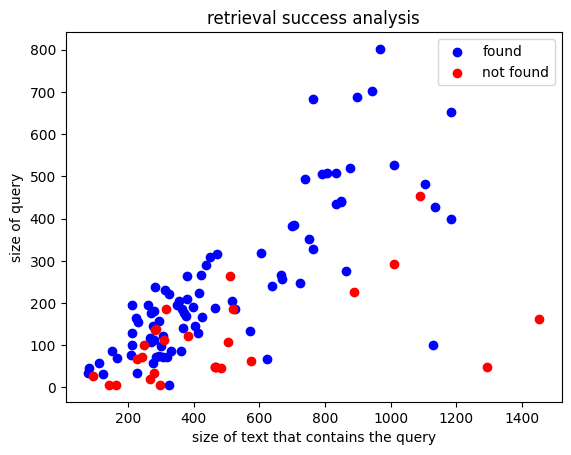

In [28]:
import matplotlib.pyplot as plt

# Visual representation of the retrieval success as a ratio between the size of the query and the size of the text that contains the query

plt.figure()
plt.scatter(positiveResults_X, positiveResults_Y, c='b',label='found')
plt.scatter(negativeResults_X, negativeResults_Y, c='r',label='not found')
plt.title("retrieval success analysis: ratio query/text")
plt.xlabel("size of text that contains the query")
plt.ylabel("size of query")
plt.legend()
plt.show()